In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import pickle


In [5]:
df = pd.read_csv(r"C:\Users\Ramya\Downloads\Reviews.csv.zip")
df = df[['Text','Score']].dropna()
df.head()


,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [6]:
def map_rating(score):
    if score <= 2:
        return 0   # Negative
    elif score == 3:
        return 1   # Neutral
    else:
        return 2   # Positive

df['Sentiment'] = df['Score'].apply(map_rating)
df[['Text','Score','Sentiment']].head()


,Text,Score,Sentiment
0,I have bought several of the Vitality canned d...,5,2
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,2
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,2


In [8]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')   # 👈 this is the missing one
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ramya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# 1️⃣ Install swifter (run once in your notebook or terminal)
# !pip install swifter

import nltk, re, string
from nltk.corpus import stopwords
import swifter  # Import swifter for parallel processing

nltk.download('stopwords')

# 2️⃣ Define stopwords once
stop_words = set(stopwords.words('english'))
custom_stopwords = stop_words - {"not", "no", "never"}   # keep negations

# 3️⃣ Optimized cleaning function
def clean_text_fast(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize using split() and remove stopwords
    tokens = [w for w in text.split() if w not in custom_stopwords]
    
    return " ".join(tokens)

# 4️⃣ Apply to entire dataframe using swifter
df['Cleaned_Text'] = df['Text'].swifter.apply(clean_text_fast)

# 5️⃣ Check results
df[['Text','Cleaned_Text']].head(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Pandas Apply: 100%|█████████████████████████████████████████████████████████| 568454/568454 [00:37<00:00, 15122.88it/s]


,Text,Cleaned_Text
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...
5,I got a wild hair for taffy and ordered this f...,got wild hair taffy ordered five pound bag taf...
6,This saltwater taffy had great flavors and was...,saltwater taffy great flavors soft chewy candy...
7,This taffy is so good. It is very soft and ch...,taffy good soft chewy flavors amazing would de...
8,Right now I'm mostly just sprouting this so my...,right im mostly sprouting cats eat grass love ...
9,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...


NB Accuracy: 0.80525


C:\Users\Ramya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ramya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ramya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.19      0.31       577
           1       0.00      0.00      0.00       304
           2       0.80      1.00      0.89      3119

    accuracy                           0.81      4000
   macro avg       0.55      0.40      0.40      4000
weighted avg       0.75      0.81      0.74      4000



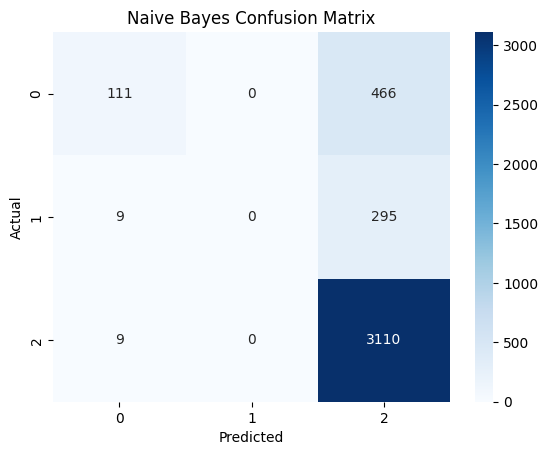

In [23]:
df_sample = df.sample(20000, random_state=42)  # comment this line to use full dataset
X = df_sample['Cleaned_Text']
y = df_sample['Sentiment']

# 3️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4️⃣ TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 5️⃣ Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# 6️⃣ Predict on test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# 7️⃣ Evaluation
print("NB Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

# 8️⃣ Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
# ----------------------------
# Module 5: LSTM Model
# ----------------------------

# 1️⃣ Imports
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 2️⃣ Encode sentiment labels
le = LabelEncoder()
y_encoded = le.fit_transform(df_sample['Sentiment'])  # 0 = negative, 1 = positive

# 3️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_sample['Cleaned_Text'], y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 4️⃣ Tokenize text
max_words = 10000  # max number of words in vocabulary
max_len = 100      # max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# 5️⃣ Build LSTM model
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# 6️⃣ Train model
history = model.fit(
    X_train_pad, y_train,
    epochs=5,              # increase epochs for better accuracy
    batch_size=64,
    validation_split=0.1
)

# 7️⃣ Evaluate model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"LSTM Test Accuracy: {accuracy*100:.2f}%")


C:\Users\Ramya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 85s 356ms/step - accuracy: 0.0765 - loss: -16.5950 - val_accuracy: 0.0725 - val_loss: -26.2361
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 351ms/step - accuracy: 0.0763 - loss: -35.8607 - val_accuracy: 0.0725 - val_loss: -44.0508
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 80s 355ms/step - accuracy: 0.0763 - loss: -53.8446 - val_accuracy: 0.0725 - val_loss: -61.5878
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 76s 339ms/step - accuracy: 0.0763 - loss: -71.5528 - val_accuracy: 0.0725 - val_loss: -79.0152
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 362ms/step - accuracy: 0.0763 - loss: -89.1936 - val_accuracy: 0.0725 - val_loss: -96.6161
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.0760 - loss: -98.2393
LSTM Test Accuracy: 7.60%


In [25]:
import pickle
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"))
model.save("lstm_model.h5")


In [26]:
import pickle
from tensorflow.keras.models import save_model

# 1️⃣ Save the tokenizer (same as before)
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# 2️⃣ Save the LSTM model in native Keras format (.keras)
model.save("lstm_model.keras")

print("Tokenizer and LSTM model saved successfully!")


Tokenizer and LSTM model saved successfully!


In [27]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Save TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Save Naive Bayes model
with open("nb_model.pkl", "wb") as f:
    pickle.dump(nb_model, f)

print("TF-IDF vectorizer and Naive Bayes model saved successfully!")


TF-IDF vectorizer and Naive Bayes model saved successfully!
